In [1]:
import numpy as np
import cv2 
import re
from PIL import Image
import pandas as pd
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm_notebook as tqdm 
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
from torchvision.transforms import Compose, ToTensor, Normalize

# define crop transform of your choice
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = Compose([ToTensor(),
                     Normalize(mean, std)])

In [3]:
# front images for each id
views = pd.read_csv('dataset/views.csv', index_col=0)
views.index = views.index.astype(str)
views.filename = views.filename.apply(eval)

# pairs including 50% of same identities
pairs = pd.read_csv('dataset/pairs.csv')

In [4]:
views.head()

,filename,person_id.1
person_id,,
90003,"[90003d17.jpg, 90003d18.jpg, 90003d40.jpg, 900...",90003
90004,"[90004d17.jpg, 90004d18.jpg, 90004d40.jpg, 900...",90004
90005,"[90005d17.jpg, 90005d18.jpg, 90005d40.jpg, 900...",90005
90006,"[90006d14.jpg, 90006d15.jpg, 90006d37.jpg, 900...",90006
90007,"[90007d17.jpg, 90007d18.jpg, 90007d36.jpg, 900...",90007


In [5]:
pairs.head()

,id_1,id_2,label
0,90308,90308,Same
1,90404,90404,Same
2,90062,90062,Same
3,90052,90052,Same
4,90144,90144,Same


### For siamese classification & similarity learning

In [7]:
def imread(path):
    img = cv2.imread(os.path.join(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def parse_keypoints(kp_raw):
    data = list(kp_raw.apply(eval))
    return np.array(data)
    
class TwinPairsDataset(Dataset):
    def __init__(self, dataroot, df_pairs, df_views, transform=transform, keypoints=False):
        '''
        dataroot: path to folder with items
        df_pairs: pd dataframe containing pairs of ids and a correspodind label:
                    'Same', 'Fraternal', 'Identical', 'UnknownTwinType',
                    'IdenticalMirror', 'Sibling', 'IdenticalTriplet'
        df_views: pd dataframe containing list of available for each id in the dataset                    
        transform: torchvision transform
        '''
        self.dataroot = dataroot
        self.df_pairs = df_pairs
        self.df_views = df_views
        self.transform = transform
        self.keypoints = keypoints
        
    def __getitem__(self, index):
        def get_img_path(person_id, view):
            path = os.path.join(self.dataroot, person_id, view)
            return imread(path)
        
        id_1, id_2  = self.df_pairs.iloc[index][['id_1', 'id_2']].values
        print(id_1, id_2)
        id_1 = str(id_1)
        id_2 = str(id_2)
        label = int(self.df_pairs.iloc[index].label=='Same')
        
        if id_1==id_2:
             view_1, view_2 = np.random.choice(self.df_views.loc[id_1]['filename'], size=2, replace=False) 
        else:
            view_1 = np.random.choice(self.df_views.loc[id_1]['filename'])
            view_2 = np.random.choice(self.df_views.loc[id_2]['filename'])

        path_1 = os.path.join(self.dataroot, id_1, view_1)
        path_2 = os.path.join(self.dataroot, id_2, view_2)
        
        img_1 = imread(path_1)
        img_2 = imread(path_2)
        
        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
            
        sample = {'img_1': img_1, 'img_2': img_2, 'label': label}
        
        if self.keypoints:
            kp_df_1 = pd.read_csv(os.path.join(self.dataroot, id_1, 'keypoints.csv'))
            kp_df_2 = pd.read_csv(os.path.join(self.dataroot, id_2, 'keypoints.csv'))
            keypoints_1 = parse_keypoints(kp_df_1[view_1])
            keypoints_2 = parse_keypoints(kp_df_2[view_2])
            
            sample['keypoints_1'] = keypoints_1
            sample['keypoints_2'] = keypoints_2
           
        return sample
    
    def __len__(self):
        return self.df_pairs.shape[0]
    

In [26]:
ROOT = '../../../../data/twins_aligned_resized'

In [27]:
dataset = TwinPairsDataset(ROOT, pairs, views, keypoints=True)

90190 90190


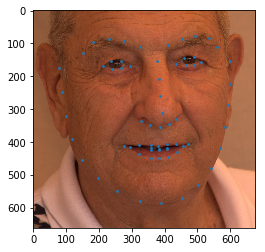

In [35]:
idx = 21
sample = dataset[idx]
plt.imshow(sample['img_1'].numpy().transpose(1,2,0)*std+mean)
kp = sample['keypoints_1']
plt.scatter(kp[:,0], kp[:,1], s=3)

### WIP for arcface/cosface